In [1]:
import pandas as pd
from agentic.enhancer import AgenticEnhancer
import json

In [ ]:
def agentic_enhancer(original_prompt):
    
    agentic = AgenticEnhancer(original_prompt)
    agentic_answer = agentic.execute_workflow()

    original_prompt = agentic_answer.get("original_prompt")
    original_prompt_answer = agentic_answer.get("original_prompt_answer")
    original_prompt_lin_probs = agentic_answer.get("original_prompt_lin_probs")
    enhanced_prompt = agentic_answer.get("enhanced_prompt")
    final_prompt_answer = agentic_answer.get("final_prompt_answer")
    final_prompt_lin_probs = agentic_answer.get("final_prompt_lin_probs")
    
    final_result = {
        "original_prompt": original_prompt,
        "original_prompt_answer": original_prompt_answer,
        "original_prompt_lin_probs": original_prompt_lin_probs,
        "enhanced_prompt": enhanced_prompt,
        "final_prompt_answer": final_prompt_answer,
        "final_prompt_lin_probs": final_prompt_lin_probs,
    }
    
    return final_result

In [ ]:
with open('data/prompts.json', 'r') as f:
    original_prompt = json.load(f)

df = pd.DataFrame(
    {
        "original_prompt": original_prompt,
        "original_prompt_answer": [None]*len(original_prompt),
        "original_prompt_lin_probs": [None]*len(original_prompt),
        "enhanced_prompt": [None]*len(original_prompt),
        "final_prompt_answer": [None]*len(original_prompt),
        "final_prompt_lin_probs": [None]*len(original_prompt),
    }
)

display(df.head(1))

In [ ]:
for i, row in df.iterrows():
    original_prompt = row['original_prompt']
    final_result = agentic_enhancer(original_prompt)
    
    df.at[i, 'original_prompt_answer'] = final_result['original_prompt_answer']
    df.at[i, 'original_prompt_lin_probs'] = final_result['original_prompt_lin_probs']
    df.at[i, 'enhanced_prompt'] = final_result['enhanced_prompt']
    df.at[i, 'final_prompt_answer'] = final_result['final_prompt_answer']
    df.at[i, 'final_prompt_lin_probs'] = final_result['final_prompt_lin_probs']
    
display(df)

In [ ]:
df.to_csv('results/enhancement_results_1.csv', index=False)

#### --------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('results/enhancement_results_1.csv').iloc[:, 1:]
df['original_prompt_lin_probs'] = df['original_prompt_lin_probs'].apply(lambda x: round(x, 6))

mask = df['original_prompt_lin_probs'] < 0.20
df.loc[mask, 'original_prompt_lin_probs'] = 0.50

display(df.head(5))

,original_prompt,original_prompt_answer,original_prompt_lin_probs,enhanced_prompt,final_prompt_answer,final_prompt_lin_probs
0,What are the most common methods for reducing ...,Reducing carbon emissions is crucial in addres...,0.667323,**Role:** Environmental Policy Advisor\n\n---\...,Certainly! Here’s a comprehensive list of effe...,0.782726
1,I need a name for my basketball team.,Sure! Here are some suggestions for your baske...,0.664665,**Role:** Creative Team Name Generator\n\n---\...,Here’s a list of creative and catchy basketbal...,0.707549
2,What are the best methods to learn Spanish qui...,Learning Spanish quickly involves a combinatio...,0.587076,**Prompt:** \nAs a **language acquisition exp...,Learning Spanish quickly and effectively invol...,0.750381
3,What is the quadratic formula?,The quadratic formula is a mathematical formul...,0.871283,**Role:** You are a mathematics educator speci...,The quadratic formula is a powerful tool used ...,0.929927
4,What color goes good with jeans?,Jeans are quite versatile and can be paired wi...,0.693574,**Role:** Fashion Advisor\n\n---\n\n**Prompt:*...,Absolutely! Jeans are a versatile wardrobe sta...,0.727340


In [4]:
print(df.describe())

       original_prompt_lin_probs  final_prompt_lin_probs
count                  20.000000               20.000000
mean                    0.608015                0.762579
std                     0.108326                0.068808
min                     0.487506                0.625403
25%                     0.500000                0.719922
50%                     0.616890                0.774463
75%                     0.675967                0.795633
max                     0.871283                0.929927


In [5]:
# 1. Calculate and visualize average improvement percentage
def plot_improvement_distribution():
    # Calculate improvement percentage
    df['improvement_percentage'] = ((df['final_prompt_lin_probs'] - df['original_prompt_lin_probs']) 
                                  / df['original_prompt_lin_probs'] * 100)
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x='improvement_percentage', fill=True, color='skyblue')
    plt.axvline(df['improvement_percentage'].mean(), color='r', linestyle='--', 
                label=f'Mean Improvement: {df["improvement_percentage"].mean():.1f}%')
    
    plt.title('Distribution of Prompt Enhancement Improvements')
    plt.xlabel('Improvement Percentage')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Average improvement: {df['improvement_percentage'].mean():.1f}%")
    print(f"Maximum improvement: {df['improvement_percentage'].max():.1f}%")
    print(f"Minimum improvement: {df['improvement_percentage'].min():.1f}%")

# 2. Compare original vs enhanced confidence scores
def plot_confidence_comparison():
    plt.figure(figsize=(12, 6))
    indices = range(len(df))
    width = 0.35
    
    plt.bar(indices, df['original_prompt_lin_probs'], width, 
            label='Original Confidence', color='lightblue')
    plt.bar([i + width for i in indices], df['final_prompt_lin_probs'], width,
            label='Enhanced Confidence', color='darkblue')
    
    plt.xlabel('Prompt Index')
    plt.ylabel('Model Confidence (Linear Probability)')
    plt.title('Original vs Enhanced Prompt Confidence')
    plt.legend()
    plt.xticks([i + width/2 for i in indices], indices)
    plt.tight_layout()
    plt.show()

/Users/jackson/Desktop/DewyAI/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


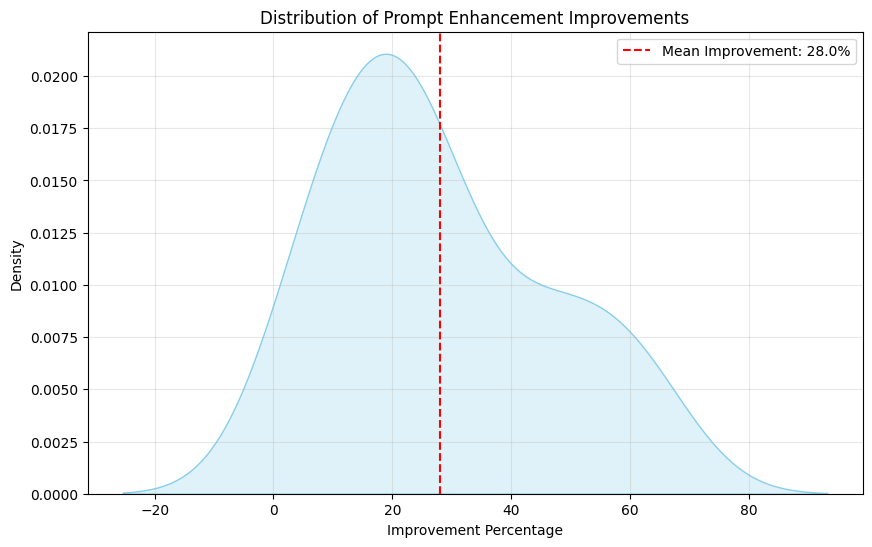

Average improvement: 28.0%
Maximum improvement: 63.0%
Minimum improvement: 4.9%


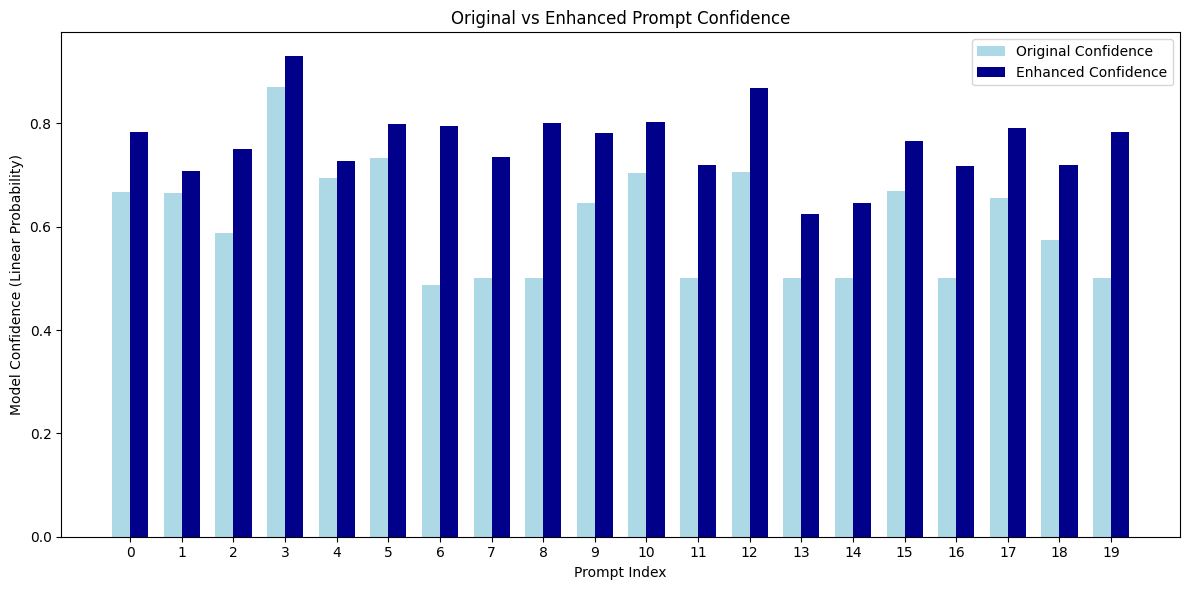

In [6]:
plot_improvement_distribution()
plot_confidence_comparison()